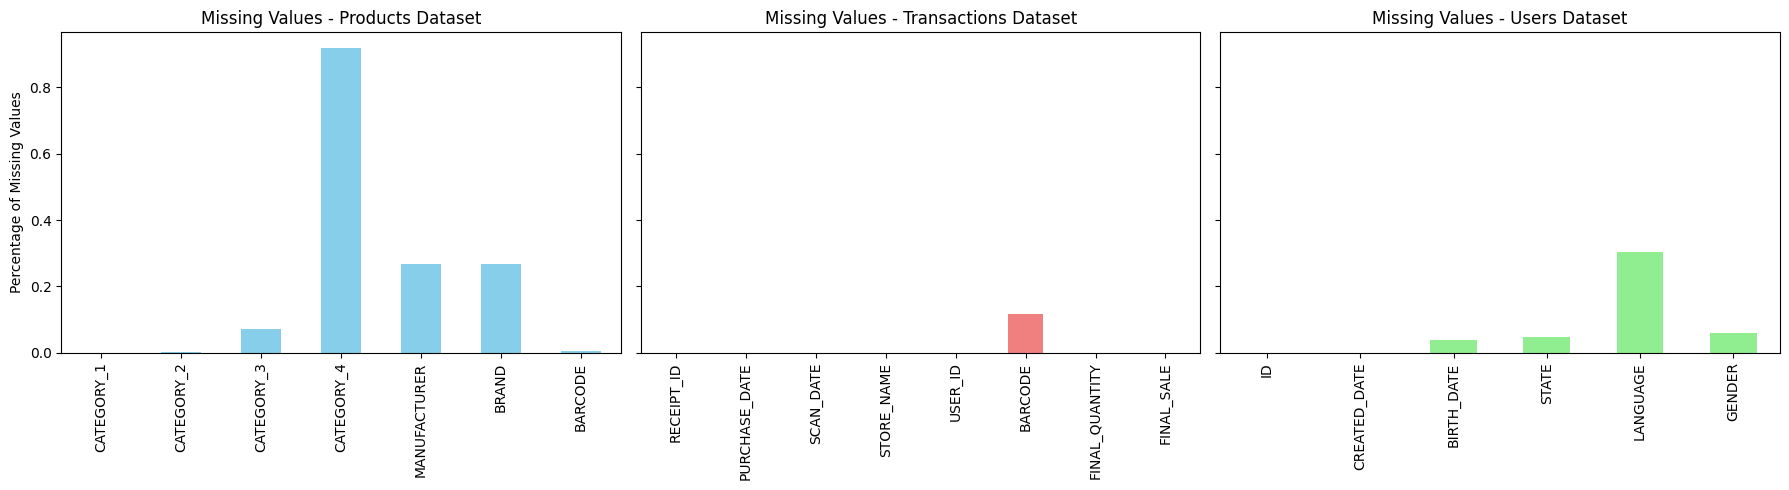

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
products_file = "PRODUCTS_TAKEHOME.csv"
transactions_file = "TRANSACTION_TAKEHOME.csv"
users_file = "USER_TAKEHOME.csv"

# Load data
df_products = pd.read_csv(products_file)
df_transactions = pd.read_csv(transactions_file)
df_users = pd.read_csv(users_file)

# Create subplots for missing values in each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Products dataset missing values
df_products.isnull().mean().plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Missing Values - Products Dataset")
axes[0].set_ylabel("Percentage of Missing Values")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Transactions dataset missing values
df_transactions.isnull().mean().plot(kind="bar", ax=axes[1], color="lightcoral")
axes[1].set_title("Missing Values - Transactions Dataset")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

# Users dataset missing values
df_users.isnull().mean().plot(kind="bar", ax=axes[2], color="lightgreen")
axes[2].set_title("Missing Values - Users Dataset")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


<ipython-input-11-1ba77cab95dd>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


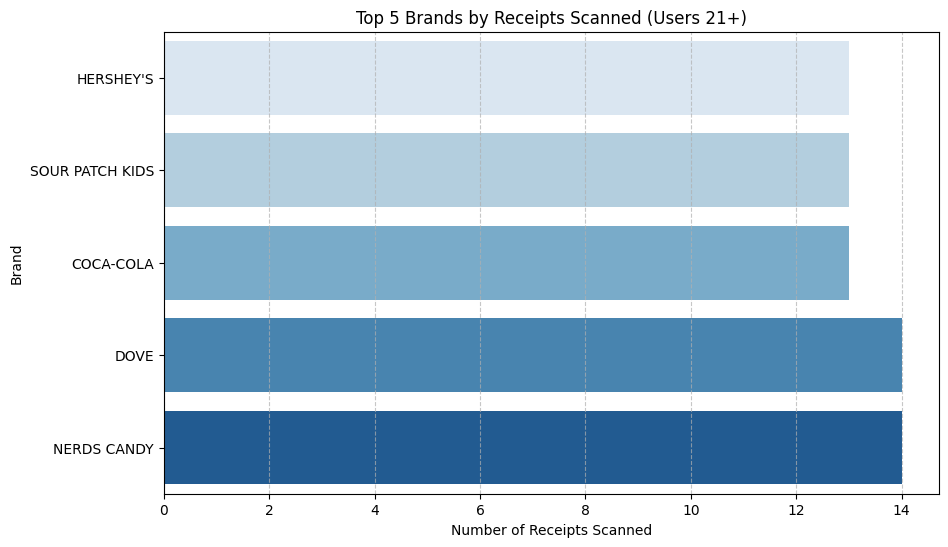

In [11]:
# Strip column names to remove any extra spaces
df_transactions.columns = df_transactions.columns.str.strip()
df_users.columns = df_users.columns.str.strip()
df_products.columns = df_products.columns.str.strip()

# Convert date columns to datetime format
df_users["BIRTH_DATE"] = pd.to_datetime(df_users["BIRTH_DATE"], errors="coerce")
df_transactions["PURCHASE_DATE"] = pd.to_datetime(df_transactions["PURCHASE_DATE"], errors="coerce")

# Merge datasets correctly (fixing the KeyError)
merged_df = df_transactions.merge(df_users, left_on="USER_ID", right_on="ID", how="inner") \
                           .merge(df_products, on="BARCODE", how="inner")

# Calculate Age at Purchase
merged_df["AGE_AT_PURCHASE"] = merged_df.apply(
    lambda row: row["PURCHASE_DATE"].year - row["BIRTH_DATE"].year -
                (1 if (row["PURCHASE_DATE"].month, row["PURCHASE_DATE"].day) <
                      (row["BIRTH_DATE"].month, row["BIRTH_DATE"].day) else 0),
    axis=1
)

# Filter for users 21 and older
filtered_df = merged_df[(merged_df["AGE_AT_PURCHASE"] >= 21) & (merged_df["BRAND"].notna())]

# Count unique receipts per brand
top_brands = (
    filtered_df.groupby("BRAND")["RECEIPT_ID"]
    .nunique()
    .reset_index()
    .rename(columns={"RECEIPT_ID": "RECEIPT_COUNT"})
    .sort_values(by="RECEIPT_COUNT", ascending=False)
    .head(5)
)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_brands,
    x="RECEIPT_COUNT",
    y="BRAND",
    palette="Blues_r"
)

# Add labels and title
plt.xlabel("Number of Receipts Scanned")
plt.ylabel("Brand")
plt.title("Top 5 Brands by Receipts Scanned (Users 21+)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

<ipython-input-13-d3af14d96535>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_brands, x="FINAL_SALE", y="BRAND", palette="Reds_r")


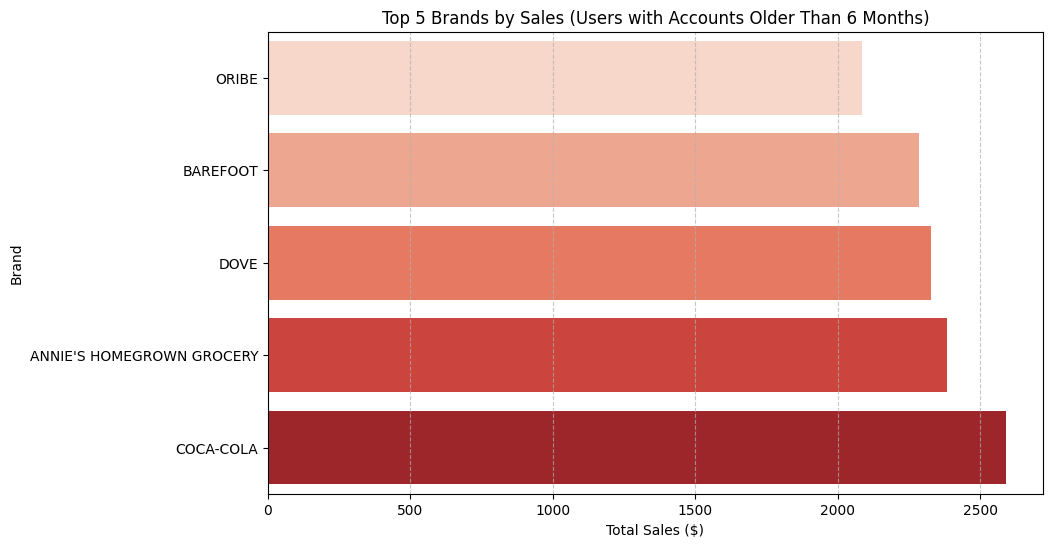

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date columns to datetime format (force naive timestamps to prevent errors)
df_users["CREATED_DATE"] = pd.to_datetime(df_users["CREATED_DATE"], errors="coerce").dt.tz_localize(None)
df_transactions["PURCHASE_DATE"] = pd.to_datetime(df_transactions["PURCHASE_DATE"], errors="coerce").dt.tz_localize(None)

# Filter users who have had an account for at least 6 months before the purchase date
df_users["ELIGIBLE_DATE"] = df_users["CREATED_DATE"] + pd.DateOffset(months=6)
df_eligible_transactions = df_transactions.merge(df_users, left_on="USER_ID", right_on="ID", how="inner")

# Ensure both dates are timezone-naive before comparison
df_eligible_transactions = df_eligible_transactions[df_eligible_transactions["PURCHASE_DATE"] >= df_eligible_transactions["ELIGIBLE_DATE"]]

# Merge with product data
df_eligible_transactions = df_eligible_transactions.merge(df_products, on="BARCODE", how="inner")

# Clean FINAL_SALE column (replace "zero" and empty values with 0)
df_eligible_transactions["FINAL_SALE"] = pd.to_numeric(df_eligible_transactions["FINAL_SALE"], errors="coerce").fillna(0)

# Aggregate total sales by brand
df_top_brands = df_eligible_transactions.groupby("BRAND")["FINAL_SALE"].sum().reset_index()

# Get top 5 brands by sales
df_top_brands = df_top_brands.sort_values(by="FINAL_SALE", ascending=False).head(5)

# Plot the top 5 brands by sales
plt.figure(figsize=(10, 6))
sns.barplot(data=df_top_brands, x="FINAL_SALE", y="BRAND", palette="Reds_r")

# Labels and title
plt.xlabel("Total Sales ($)")
plt.ylabel("Brand")
plt.title("Top 5 Brands by Sales (Users with Accounts Older Than 6 Months)")
plt.gca().invert_yaxis()  # Invert for readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


Filtered Data Sample:
                               RECEIPT_ID PURCHASE_DATE  \
5   04e48cb8-ee37-49a8-9d4a-4331a06fe687    2024-08-06   
10  151a041b-097d-409a-88ee-a879043e41f3    2024-06-29   
14  1b81676d-750e-42d6-970c-b9432b09934f    2024-07-08   
17  1b81676d-750e-42d6-970c-b9432b09934f    2024-07-08   
18  1b81676d-750e-42d6-970c-b9432b09934f    2024-07-08   

                    SCAN_DATE STORE_NAME                   USER_ID  \
5   2024-08-06 14:12:05.106 Z    WALMART  64dd9170516348066e7c4006   
10  2024-06-30 10:59:42.756 Z    WALMART  61a3e9a55e388d4f51377186   
14  2024-07-08 23:27:59.639 Z       LODE  610a8541ca1fab5b417b5d33   
17  2024-07-08 23:27:59.639 Z       LODE  610a8541ca1fab5b417b5d33   
18  2024-07-08 23:27:59.639 Z       LODE  610a8541ca1fab5b417b5d33   

         BARCODE FINAL_QUANTITY  FINAL_SALE                        ID  \
5   1.111161e+10           zero       11.97  64dd9170516348066e7c4006   
10  6.811319e+11           1.00        0.00  61a3e9a55e388d4f

<ipython-input-27-449b9a79b202>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_health_wellness["generation"] = df_health_wellness["BIRTH_DATE"].dt.year.apply(get_generation)
<ipython-input-27-449b9a79b202>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=generation_sales, x="percentage_sales", y="generation", palette="viridis")


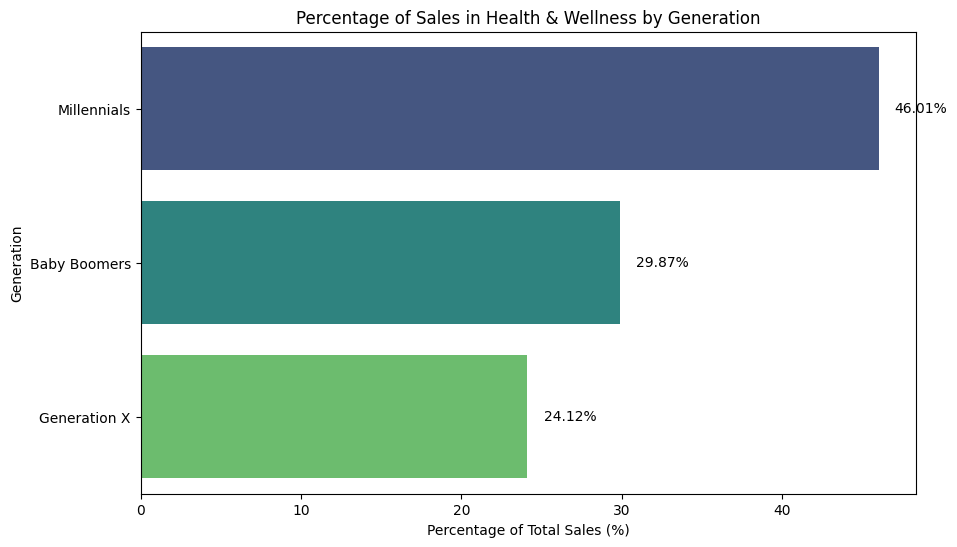

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert dates to datetime format
df_users["BIRTH_DATE"] = pd.to_datetime(df_users["BIRTH_DATE"], errors="coerce")
df_transactions["FINAL_SALE"] = pd.to_numeric(df_transactions["FINAL_SALE"], errors="coerce")

# Merge datasets
df_merged = df_transactions.merge(df_users, left_on="USER_ID", right_on="ID", how="inner") \
                           .merge(df_products, on="BARCODE", how="inner")

# Filter for Health & Wellness category
df_health_wellness = df_merged[df_merged["CATEGORY_1"] == "Health & Wellness"]

# Debug: Check if data is filtered correctly
print("Filtered Data Sample:\n", df_health_wellness.head())

# Define generations
def get_generation(year):
    if pd.isna(year):
        return "Other"
    if 1946 <= year <= 1964:
        return "Baby Boomers"
    elif 1965 <= year <= 1980:
        return "Generation X"
    elif 1981 <= year <= 1996:
        return "Millennials"
    elif year >= 1997:
        return "Generation Z"
    else:
        return "Other"

df_health_wellness["generation"] = df_health_wellness["BIRTH_DATE"].dt.year.apply(get_generation)

# Debug: Print unique generations assigned
print("Unique Generations in Data:", df_health_wellness["generation"].unique())

# Aggregate total sales by generation
generation_sales = df_health_wellness.groupby("generation")["FINAL_SALE"].sum().reset_index()

# Calculate percentage sales
total_sales = generation_sales["FINAL_SALE"].sum()
generation_sales["percentage_sales"] = round((generation_sales["FINAL_SALE"] / total_sales) * 100, 2)

# Debug: Print final generation sales dataframe
print("Generation Sales Data:\n", generation_sales)

# Sort by percentage sales
generation_sales = generation_sales.sort_values(by="percentage_sales", ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=generation_sales, x="percentage_sales", y="generation", palette="viridis")

# Labels and title
plt.xlabel("Percentage of Total Sales (%)")
plt.ylabel("Generation")
plt.title("Percentage of Sales in Health & Wellness by Generation")

# Show values on bars
for index, value in enumerate(generation_sales["percentage_sales"]):
    plt.text(value + 1, index, f"{value:.2f}%", va="center")

plt.show()


Top 3 Power Users:
                 USER_ID  TRANSACTION_COUNT
62925c1be942f00613f7365e                 10
64e62de5ca929250373e6cf5                 10
64063c8880552327897186a5                  9


<ipython-input-23-3f91b77b28ce>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_power_users, x="USER_ID", y="TRANSACTION_COUNT", palette="Reds")


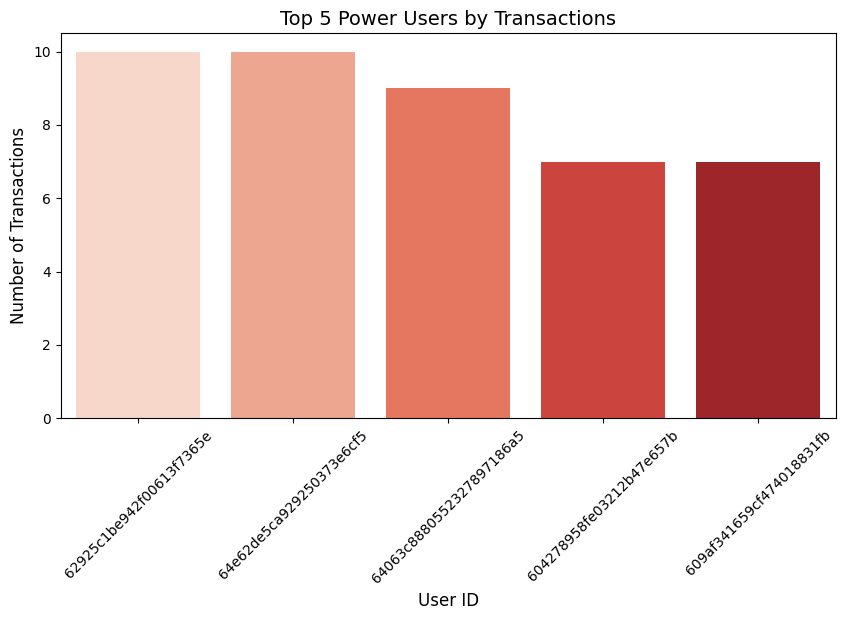

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count distinct transactions per user
user_activity = df_transactions.groupby("USER_ID")["RECEIPT_ID"].nunique().reset_index()
user_activity.columns = ["USER_ID", "TRANSACTION_COUNT"]

# Filter users with at least 2 transactions
user_activity = user_activity[user_activity["TRANSACTION_COUNT"] >= 2]

# Compute 75th percentile threshold
percentile_75 = user_activity["TRANSACTION_COUNT"].quantile(0.75)

# Label power users
user_activity["Power User"] = user_activity["TRANSACTION_COUNT"].apply(lambda x: "Power User" if x >= percentile_75 else "Regular User")

# Get the top 5 Power Users for visualization
top_5_power_users = user_activity[user_activity["Power User"] == "Power User"].nlargest(5, "TRANSACTION_COUNT")

# Get the first 3 Power Users for the table
top_3_power_users = top_5_power_users.head(3)

# Display as a table
print("Top 3 Power Users:")
print(top_3_power_users[["USER_ID", "TRANSACTION_COUNT"]].to_string(index=False))

# Visualization - Show only the top 5 Power Users
plt.figure(figsize=(10, 5))
sns.barplot(data=top_5_power_users, x="USER_ID", y="TRANSACTION_COUNT", palette="Reds")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=10)

plt.title("Top 5 Power Users by Transactions", fontsize=14)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

# Show plot
plt.show()
